In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import copy
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# for creating validation set
from sklearn.model_selection import train_test_split

%matplotlib notebook
%matplotlib notebook
# %matplotlib inline
# %matplotlib qt

In [3]:
import sys

sys.path.append(r'/media/rich/Home_Linux_partition/github_repos')
# sys.path.append('/Users/Josh/Documents/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, decomposition
from GCaMP_ROI_classifier.old_stuff import util, models, training_simCLR, augmentation, training_classHead

## Import training data

In [4]:
import pickle

# with open('/Users/Josh/Documents/Harvard/label_data/all_stat_files_20211022.pkl', 'rb') as file:
with open('/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data/all_stat_files_20211022.pkl', 'rb') as file:
    statFiles_scraped = pickle.load(file)

In [5]:
keys_toDelete = [
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\16x_analysis20200514\\Suite2p and MC for denoised movie\\suite2p\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20201102\\suite2p_accidentally_run_on_everything\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attemp 2 _tau 1_5\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 1 _tau 2\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\20x\\mouse 2.5\\20200306\\suite2p attempt 3 _tau 1\\plane0\\stat.npy',
    '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\for Loic\\AAV\\oldBMIrampExp_20191112_mouse1013A\\ROI extraction\\suite2p\\plane0\\stat.npy',
]
for key in keys_toDelete:
    del statFiles_scraped[key]

In [24]:
sf_list = util.convert_multiple_stat_files(statFiles_dict=statFiles_scraped, out_height_width=[36,36], max_footprint_width=901, plot_pref=False)

# images_all = np.concatenate(sf_list, axis=0)
images_all = np.concatenate([sf_list[ii][:1000] for ii in range(len(sf_list))], axis=0)

images_all.shape

(83190, 36, 36)

In [25]:
images_all_norm = (images_all / np.sum(images_all, axis=(1,2), keepdims=True)) * 255

In [26]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_train, X_val, y_train, y_val = train_test_split(images_all_norm, np.arange(images_all.shape[0]), test_size = 0.15)
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)

(((70711, 36, 36), (70711,)), ((12479, 36, 36), (12479,)))

<IPython.core.display.Javascript object>


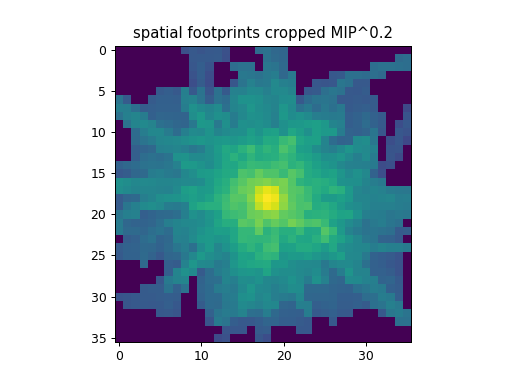

<IPython.core.display.Javascript object>


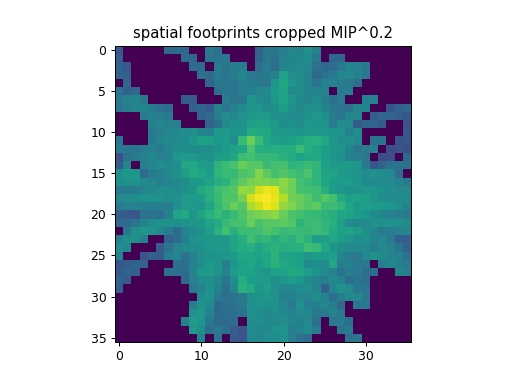

concatenated images shape: (9715, 36, 36)


<IPython.core.display.Javascript object>


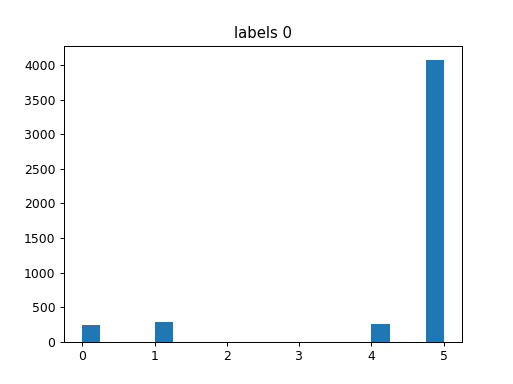

<IPython.core.display.Javascript object>


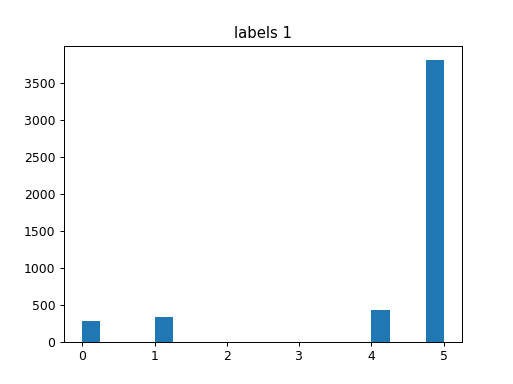

In [13]:
dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

statFile_import_kwargs = {'out_height_width': [36,36],
                          'max_footprint_width': 241,
                          'plot_pref':True}

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                        fileNames_statFiles=fileNames_statFiles,
                                        out_height_width=[36,36],
                                        max_footprint_width=241,
                                        plot_pref=True)
images_labeled = np.concatenate(sf_all, axis=0) *255
print(f'concatenated images shape: {images_labeled.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(dir_folders) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

In [14]:
# tmpd = pd.DataFrame(labels)
# tmpd[1] = tmpd[0]
# tmpd.groupby(0).count()

In [15]:
#code doesn't work with multiple open number maybe (?)

In [16]:
def squeeze_integers(arr):
    """
    Make integers in an array consecutive numbers
     starting from 0. ie. [7,2,7,4,1] -> [3,2,3,1,0].
    Useful for removing unused class IDs from y_true
     and outputting something appropriate for softmax.
    RH 2021
    Args:
        arr (np.ndarray):
            array of integers.
    
    Returns:
        arr_squeezed (np.ndarray):
            array of integers with consecutive numbers
    """
    uniques = np.unique(arr)
    arr_squeezed = copy.deepcopy(arr)
    for val in np.arange(0, np.max(arr)+1):
        if np.isin(val, uniques):
            continue
        else:
            arr_squeezed[arr_squeezed>val] = arr_squeezed[arr_squeezed>val]-1
    return arr_squeezed

In [17]:
labels = squeeze_integers(labels)
images_labeled = images_labeled[labels != 2]
labels = labels[labels != 2]
labels = squeeze_integers(labels)

## Balance classes of inputs

In [18]:
duplicates = 1

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 36, 36)
(9714,)
532
532
620
0
0
(9714, 36, 36)
(9714,)


In [20]:
# create validation set
# X_train, X_val, y_train, y_val = train_test_split(images[:], labels[:], test_size = 0.15)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.15)
(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((8256, 36, 36), (8256,)), ((1458, 36, 36), (1458,)))

<IPython.core.display.Javascript object>


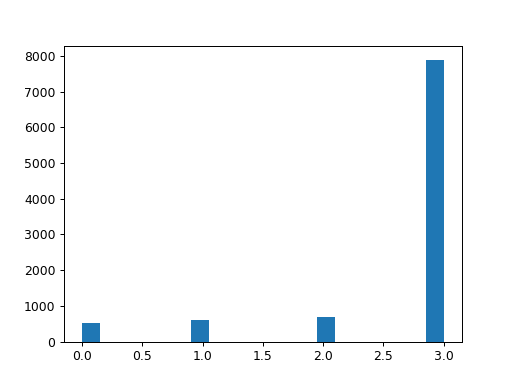

In [21]:
plt.figure()
plt.hist(labels_dup, 20);

In [22]:
def idx_to_oneHot(arr, n_classes=None):
    """
    Convert an array of class indices to matrix of
     one-hot vectors.
    RH 2021

    Args:
        arr (np.ndarray):
            1-D array of class indices.
        n_classes (int):
            Number of classes.
    
    Returns:
        oneHot (np.ndarray):
            2-D array of one-hot vectors.
    """
    if n_classes is None:
        n_classes = np.max(arr)+1
    oneHot = np.zeros((arr.size, n_classes))
    oneHot[np.arange(arr.size), arr] = 1
    return oneHot

In [23]:
def rh_cm(y_hat, y_true):
    """
    Compute the confusion matrix from y_hat and y_true.
    y_hat should be either predictions ().
    RH 2021

    Args:
        y_hat (np.ndarray): 
            numpy array of predictions or probabilities. 
            Either PREDICTIONS: 2-D array of booleans
             ('one hots') or 1-D array of predicted 
             class indices.
            Or PROBABILITIES: 2-D array floats ('one hot
             like')
        y_true (np.ndarray):
            1-D array of true class indices.
    """
    n_classes = np.max(y_true)+1
    if y_hat.ndim == 1:
        y_hat = idx_to_oneHot(y_hat, n_classes)
    cmat = y_hat.T @ idx_to_oneHot(y_true, n_classes)
    return cmat / np.sum(cmat, axis=0)[None,:]
#     return cmat / torch.sum(cmat, dim=0)[None,:]

## Define augmentation pipeline

In [37]:
import torchvision.transforms    

transforms = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    
    torchvision.transforms.GaussianBlur(kernel_size=5,
                                        sigma=(0.0001, 0.5)),
    
    torchvision.transforms.RandomPerspective(distortion_scale=0.4, 
                                             p=0.5, 
                                             interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                             fill=0),
    torchvision.transforms.RandomAffine(
                                        degrees=(-180,180),
                                        translate=(0.3, 0.3),
                                        scale=(0.7, 1.7), 
                                        shear=(-20, 20, -20, 20), 
                                        interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
                                        fill=0, 
                                        fillcolor=None, 
                                        resample=None),
    
    augmentation.AddPoissonNoise(   level_bounds=(0,0.3),
                                    prob=1),

    augmentation.AddGaussianNoise(  mean=0, 
                                    std=0.2,
                                    prob=1),
)
scripted_transforms = torch.jit.script(transforms)
# scripted_transforms = transforms



dataset_train = util.dataset_simCLR(
                                    torch.tensor(X_train), 
                                    y_train, 
#                                     torch.tensor(X_train), 
#                                     y_train, 
                                    n_transforms=2, 
#                                     class_weights=[1]*4,
#                                     class_weights=[0.34, 0.33, 0.33, 0.00],
#                                     class_weights=[0.0, 0.0, 0.0, 1.00],
#                                     class_weights=np.array([0.34, 0.33, 0.33, 0.00])[y_train],
#                                     class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64 )

dataloader_train = torch.utils.data.DataLoader( dataset_train,
                                                batch_size=4096,
            #                                     sampler=sampler,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
#                                                 num_workers=0,
                                                num_workers=32,
#                                                 prefetch_factor=0,
#                                                 persistent_workers=True,
                                                )

# dataset_val = util.dataset_simCLR(torch.tensor(X_val), 
#                                     y_val, 
#                                     n_transforms=2, 
#                                     transform=scripted_transforms,
#                                     DEVICE='cpu',
#                                     dtype_X=torch.float32,
#                                     dtype_y=torch.int64 )

# dataloader_val = torch.utils.data.DataLoader(   dataset_val,
#                                                 batch_size=128,
#             #                                     sampler=sampler,
#                                                 shuffle=True,
#                                                 drop_last=True,
#                                                 pin_memory=True,
#                                                 num_workers=0,
#                                                 )         

1
1
1
1
1


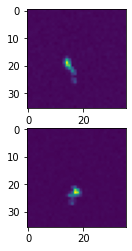

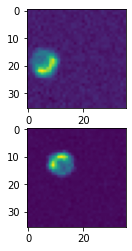

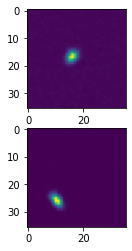

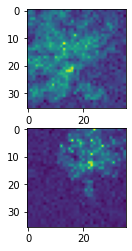

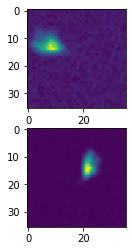

In [44]:
import time

%matplotlib inline
tic=time.time()
# for ii, im in enumerate(dataset_train):
for ii,idx in enumerate(np.random.randint(0,X_train.shape[0], 5)):
#     for jj in range(im[0])
#     print(time.time() - tic)
#     tic = time.time()
#     print((im[0][0]).shape)
    print(dataset_train[idx][3])
    fig, axs = plt.subplots(2)
    for jj, ax in enumerate(axs):
#         ax.imshow(im[0][j].cpu().squeeze())
        ax.imshow(dataset_train[idx][0][jj].cpu().squeeze())
#     if ii > 5:
#         break

## Train

In [45]:
DEVICE = torch_helpers.set_device(use_GPU=True)

device: 'cuda'


In [46]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)
model.train()
# criterion = CrossEntropyLoss()
criterion = CrossEntropyLoss(reduction='none')

optimizer = Adam(model.parameters(), lr=2e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0002,
#                                                    gamma=1,
                                                  )
# val_obj = training_simCLR.validation_Obj(   X_val,
#                                             y_val,
#                                             model,
#                                             criterion,
#                                             DEVICE=DEVICE,
#                                             dtype_X=torch.float32,
#                                             dtype_y=torch.int64) # Needs to take in weights

model.to(DEVICE)
criterion = criterion.to(DEVICE)

# # classHead = HeadModel(model, RandomForestClassifier)
# classHead = training_classHead.HeadModel(model, LogisticRegression)
# dataset_train.headmodel = classHead
# # dataset_train.headmodel = None

losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [ ]:
%matplotlib inline

logreg = LogisticRegression(solver='liblinear')
dataset_train.classification_model = None

# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
#                                                    gamma=1-0.001,
# #                                                    gamma=1,
#                                                   )
n_epochs=300000
for epoch in range(n_epochs):
    print(f'epoch: {epoch}')
    training_simCLR.epoch_step( dataloader_train, 
                                model, 
                                optimizer, 
                                criterion, 
                                scheduler=scheduler, 
                                temperature=0.5,
                                loss_rolling_train=losses_train, 
                                device=DEVICE, 
                                do_validation=False,
#                                 validation_Object=val_obj,
                                loss_rolling_val=losses_val,
                                verbose=2,
                                verbose_update_period=100,
                               )
    

    
    features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    # features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
    logreg.fit(features_train, y_labeled_train)
    acc.append(logreg.score(features_train, y_labeled_train))
    print(f'acc: {acc[-1]}')
    
    dataset_train.net_model = copy.deepcopy(model).to('cpu')
    dataset_train.classification_model = logreg
    
    
    
    # model predict
    # Update model in DS
    # get item calls model for each sample
    # output
    # X sample weights predictions
    
#     classHead.fit(X_train[:, None, :, :], y_train, solver='liblinear')
    
#     proba = classHead.predict_proba(X_train[:, None, :, :])
#     class_weights = proba.sum(axis=0)
#     total_num = class_weights.sum()
    
#     eps = 1e-4
    
#     class_weights[class_weights <= 3] = total_num
#     weightings = class_weights.sum()/class_weights
#     final_weights = weightings / weightings.sum()
#     final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])
    
#     print(class_weights)

#     dataset_train.set_classweights(final_weights)
    
#     print('dataset_train.final_weights', dataset_train.class_weights)


epoch: 0
Iter: 0/17, loss_train: 8.9753, loss_val: nan, lr: 0.0019996
acc: 0.8558624031007752
epoch: 1
Iter: 0/17, loss_train: 7.9742, loss_val: nan, lr: 0.0019928
acc: 0.8594961240310077
epoch: 2
Iter: 0/17, loss_train: 7.8683, loss_val: nan, lr: 0.001986
acc: 0.8636143410852714
epoch: 3
Iter: 0/17, loss_train: 7.7823, loss_val: nan, lr: 0.0019793
acc: 0.8687015503875969
epoch: 4
Iter: 0/17, loss_train: 7.7127, loss_val: nan, lr: 0.0019726
acc: 0.8689437984496124
epoch: 5
Iter: 0/17, loss_train: 7.661, loss_val: nan, lr: 0.0019659
acc: 0.8713662790697675
epoch: 6


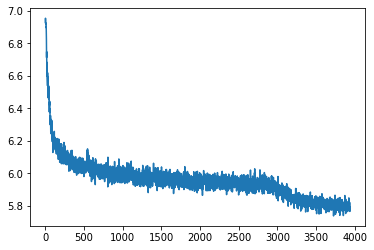

In [466]:
plt.figure()
plt.plot(losses_train)

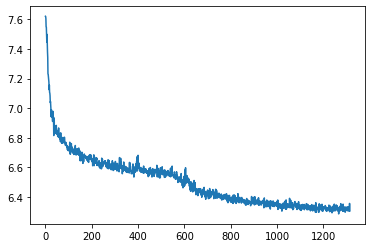

In [82]:
plt.figure()
plt.plot(losses_train)

<IPython.core.display.Javascript object>


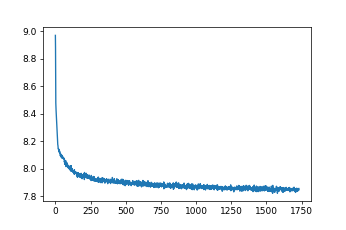

In [140]:
%matplotlib notebook
plt.figure()
plt.plot(losses_train)

<IPython.core.display.Javascript object>


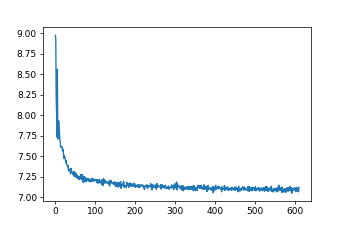

In [25]:
%matplotlib notebook
plt.figure()
plt.plot(losses_train)

<IPython.core.display.Javascript object>


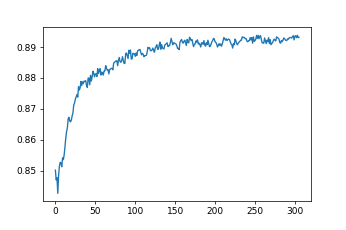

In [26]:
plt.figure()
plt.plot(acc)

<IPython.core.display.Javascript object>


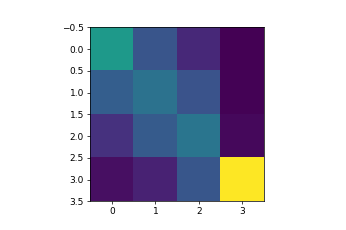

In [27]:
features_train = model(torch.as_tensor(X_labeled_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
# features = model(torch.tensor(X_train[y_train != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach().cpu()
logreg.fit(features_train, y_labeled_train)
y_hat = logreg.predict_proba(features_train)
cm = rh_cm(y_hat, y_labeled_train)

plt.figure()
plt.imshow(cm)

In [109]:
proba = classHead.predict_proba(dataset_train.X)

In [43]:
# classHead.fit(X_train[:, None, :, :], y_train)



proba = classHead.predict_proba(X_train[:, None, :, :])
final_weights = np.array([1/proba.shape[1] for _ in range(proba.shape[1])])

dataset_train.set_classweights(final_weights)


In [44]:
%load_ext autoreload
%autoreload 2

from basic_neural_processing_modules import decomposition

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
logreg = LogisticRegression(solver='liblinear')
head = classHead.get_simCLR_head(X_train[:, None, ...])
# head = classHead.norm_head(head)
# head = head[:, [_ for _ in range(64) if _ not in [7, 15, 20, 21, 36, 54, 57, 60, 61, 62, 63, 64]]]
components , scores , decomposition.explained_variance_ratio_ , stds = decomposition.simple_pca(head, n_components=None)

# logreg.fit(scores[:, :], y_train)
# logreg.predict_proba(scores[:, :])
logreg.fit(head, y_train)
logreg.predict_proba(head)

array([[7.38606327e-13, 9.82938418e-09, 5.31466834e-06, 9.99994676e-01],
       [1.62968581e-01, 2.46029907e-01, 3.00199851e-01, 2.90801661e-01],
       [2.38470334e-11, 9.68791835e-08, 2.48697816e-05, 9.99975033e-01],
       ...,
       [2.35114301e-10, 4.41739816e-07, 7.60582958e-05, 9.99923500e-01],
       [3.22474556e-06, 2.38832089e-04, 6.03245991e-03, 9.93725483e-01],
       [1.19631619e-14, 6.07571093e-10, 5.86688485e-07, 9.99999413e-01]])

<IPython.core.display.Javascript object>


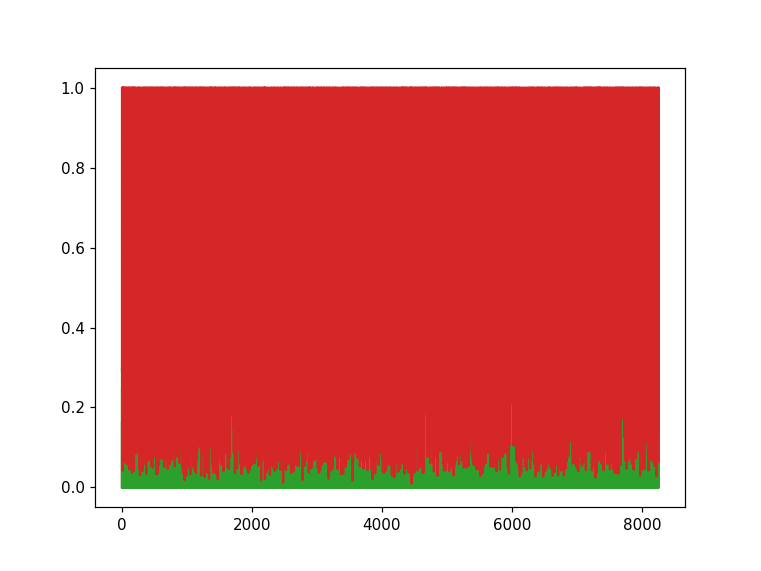

In [46]:
prd = logreg.predict_proba(head)
# prd = logreg.predict_proba(scores[:, :2])
plt.figure()
# plt.plot(logreg.predict_proba(scores[:, :2]))
plt.plot(logreg.predict_proba(head))

In [47]:
# cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(scores[:, :2]), axis=1))
cm = confusion_matrix(y_train, np.argmax(logreg.predict_proba(head), axis=1))
cm = np.round(cm/cm.sum(axis=0), 2)
cm

array([[0.45, 0.39, 0.13, 0.  ],
       [0.31, 0.35, 0.34, 0.01],
       [0.2 , 0.21, 0.34, 0.03],
       [0.03, 0.05, 0.18, 0.96]])

In [48]:
logreg.predict_proba(classHead.get_simCLR_head(X_val[:, None, :, :]))

array([[6.24413387e-04, 7.08298809e-03, 4.78895874e-02, 9.44403011e-01],
       [1.46328821e-15, 1.52492185e-10, 2.02354552e-07, 9.99999797e-01],
       [3.05682540e-14, 1.13200002e-09, 9.43359933e-07, 9.99999056e-01],
       ...,
       [9.96917403e-10, 1.15630352e-06, 1.62694854e-04, 9.99836148e-01],
       [1.47265253e-01, 2.32845574e-01, 2.86896827e-01, 3.32992347e-01],
       [2.41787743e-11, 9.68560866e-08, 2.39367315e-05, 9.99975966e-01]])

In [ ]:
classHead.fit(X_train[:, None, :, :], y_train)

In [ ]:
classHead.predict_proba(X_train[:, None, :, :])

In [ ]:
idx_sample = 5
classHead.predict_proba(X_train[idx_sample:idx_sample+1, None, ...])

In [ ]:
sample_weight = util.loss_uncertainty(torch.as_tensor(proba), temperature=1, class_value=dataset_train.class_weights)

## Check embeddings

In [305]:
torch.cuda.empty_cache()

In [33]:
features = model(torch.tensor(images_labeled, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(images_labeled[labels != 3], device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_val, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()
# features = model(torch.tensor(X_train, device=DEVICE, dtype=torch.float32)[:,None,...]).detach()

In [34]:
_, features_embedded, _, _ = decomposition.torch_pca(features, device=DEVICE, return_cpu=True)

In [36]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, 
                     perplexity=80.0, 
                     early_exaggeration=12.0, 
                     learning_rate=200, 
                     n_iter=1000, 
                     n_iter_without_progress=300, 
                     min_grad_norm=1e-07, 
                     metric='euclidean', 
                     init='pca', 
                     verbose=0, 
                     random_state=None, 
                     method='barnes_hut', 
                     angle=0.5, 
                     n_jobs=-1, 
#                      square_distances='legacy'
                    )
features_embedded = tsne.fit_transform(features.cpu())

<IPython.core.display.Javascript object>


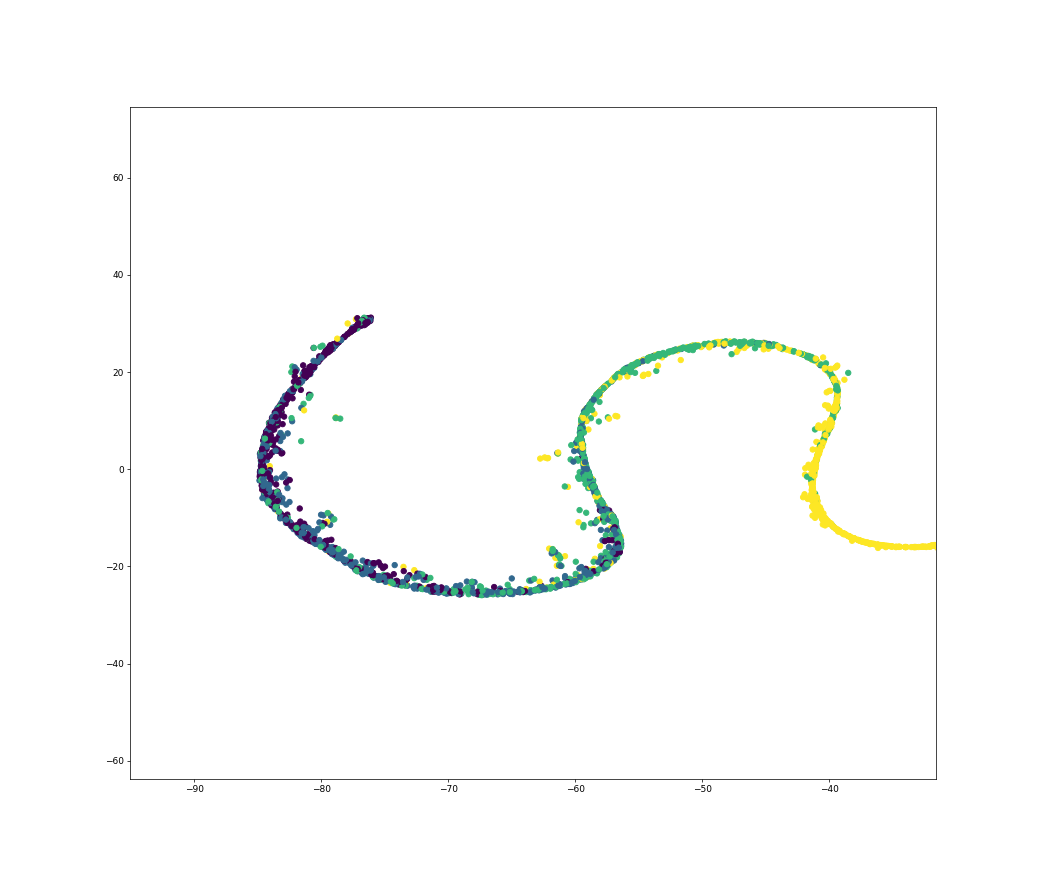

In [37]:
import matplotlib as mpl

# mpl.rcParams['image.cmap'] = 'Set1'
%matplotlib notebook
plt.figure()
plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels)
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=labels[labels!=3])
# plt.scatter(features_embedded[:,0], features_embedded[:,1], c=y_val)
# plt.scatter(features_embedded[:,4], features_embedded[:,5], c=y_train)
# plt.scatter(features_embedded[:,11], features[:,43].cpu(), c=y_train)
mpl.rcParams['image.cmap'] = 'viridis'


<IPython.core.display.Javascript object>


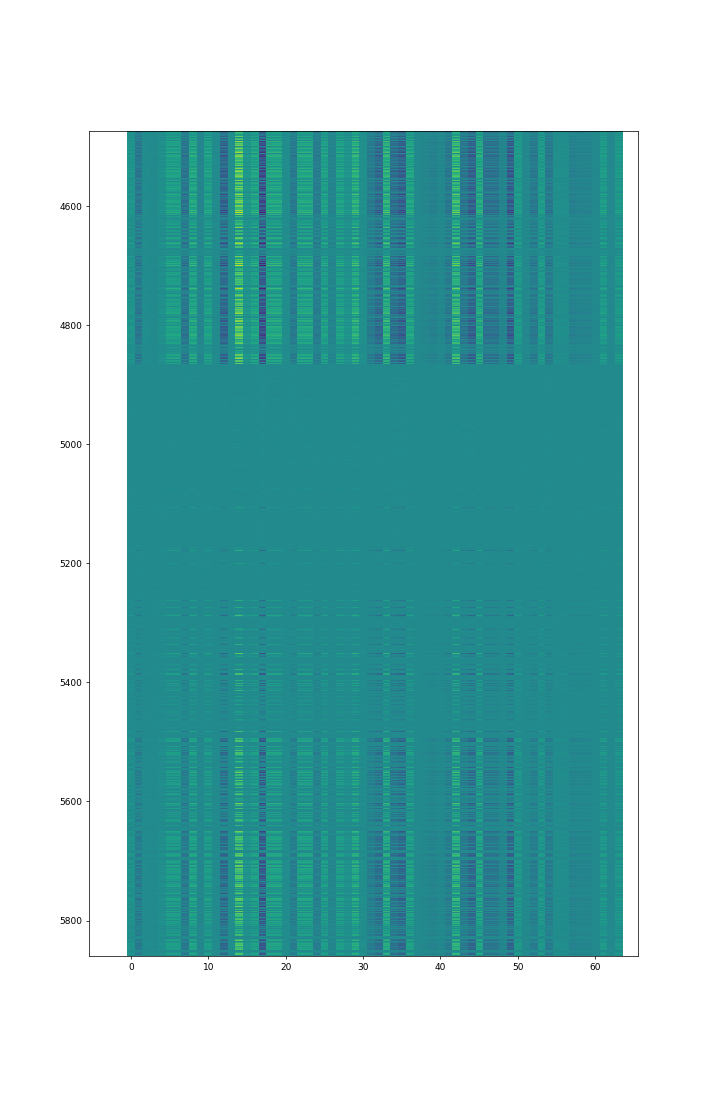

In [38]:
plt.figure()
plt.imshow(features.cpu().detach(), aspect='auto', interpolation='none')

## Check filters

In [56]:
list(model.state_dict().keys())

['cnn_layers.0.weight',
 'cnn_layers.0.bias',
 'cnn_layers.2.weight',
 'cnn_layers.2.bias',
 'cnn_layers.5.weight',
 'cnn_layers.5.bias',
 'cnn_layers.8.weight',
 'cnn_layers.8.bias',
 'linear_layers.0.weight',
 'linear_layers.0.bias',
 'linear_layers.2.weight',
 'linear_layers.2.bias']

<IPython.core.display.Javascript object>


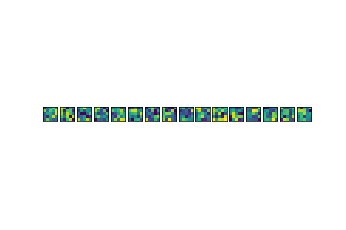

<IPython.core.display.Javascript object>


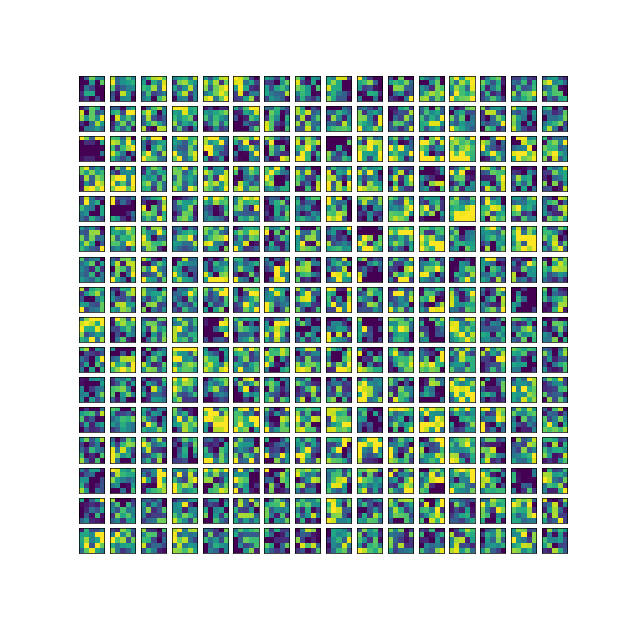

<IPython.core.display.Javascript object>


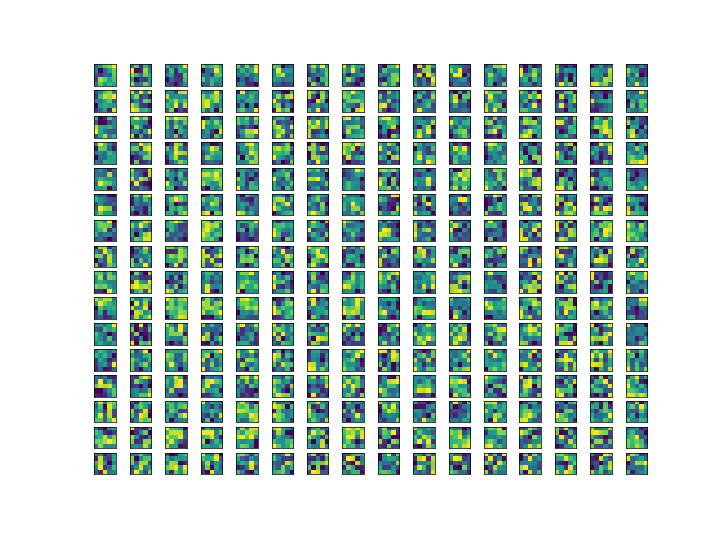

<IPython.core.display.Javascript object>


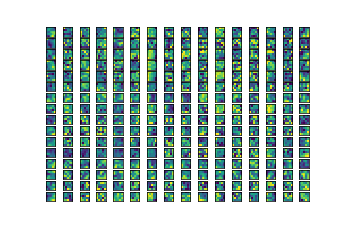

In [39]:
layer_1 = model.state_dict()['cnn_layers.0.weight'].cpu()
layer_2 = model.state_dict()['cnn_layers.2.weight'].cpu()
layer_3 = model.state_dict()['cnn_layers.5.weight'].cpu()
layer_4 = model.state_dict()['cnn_layers.8.weight'].cpu()

plt.figure()
for ii in range(layer_1.shape[1]):
    for jj in range(layer_1.shape[0]):
        plt.subplot2grid((layer_1.shape[1],layer_1.shape[0]),(ii,jj))
        fig = plt.imshow(layer_1[jj,ii,:,:] , clim=(-0.2,0.2))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(layer_2.shape[1]):
    for jj in range(layer_2.shape[0]):
        plt.subplot2grid((layer_2.shape[1],layer_2.shape[0]),(ii,jj))
        fig = plt.imshow(layer_2[jj,ii,:,:], clim=(-.05,.05))
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_3[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
plt.figure()
for ii in range(16):
    for jj in range(16):
        plt.subplot2grid((16,16),(ii,jj))
        fig = plt.imshow(layer_4[jj, ii,:,:])
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [ ]:
# torch.save(model.state_dict(), '/media/rich/bigSSD/Net_trainedOnAug_20211025_trainingSet_mouse628_20200903and20200815_simCLR.pth')

In [ ]:
# model = Net()
# model.load_state_dict(torch.load('test_save.pth'))
# model.eval()